In [54]:
from default_globals import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import romb
from tqdm import tqdm
from redshift_utils import *
from scipy.interpolate import interp1d
from utils import make_nice_plots
import h5py
from scipy import stats
import pandas as pd
import astropy.units as u
from scipy.special import chebyt

make_nice_plots()

COLORS = ['orangered', 'navy', 'teal', 'goldenrod', 'hotpink', 'indigo', 'crimson']


In [55]:
# Helper functions

def log10addexp10(a, b):
    return np.maximum(a, b) + np.log10(1 + 10**(-abs(a - b)))


def L2M(log10_Lbol):
    """
    Convert bolometric luminosity in erg/s to absolute AB magnitude at 1450 Angstrom. We use the magnitude-dependention function (Eq. 9) of Runnoe et al. (2012).
    """
    log10_Liso = log10_Lbol - np.log10(0.75)  # Viewing angle correction
    log10_nuLnu1450 = (log10_Liso - 4.74) / 0.91
    log10_Lnu1450 = log10_nuLnu1450 - np.log10((1450 * u.Angstrom).to(u.Hz, equivalencies=u.spectral()).value)

    offset = 2.5 * np.log10( 4 * np.pi * ((10 * u.pc).to(u.cm).value)**2 ) - 48.60
    absmag_ab = lambda log10_Lnu: -2.5 * log10_Lnu + offset
    return absmag_ab(log10_Lnu1450)



# Shen et al. (2020)

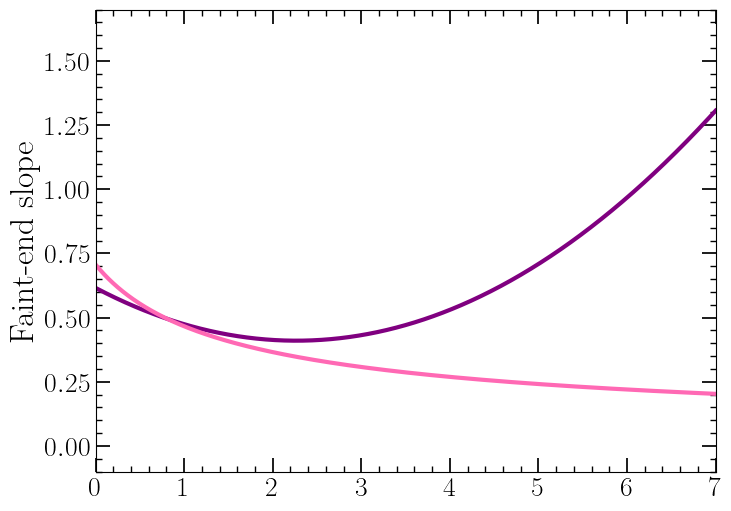

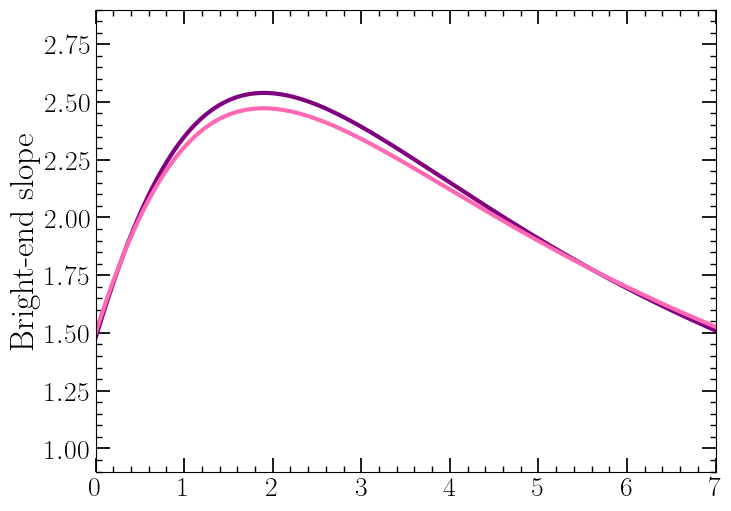

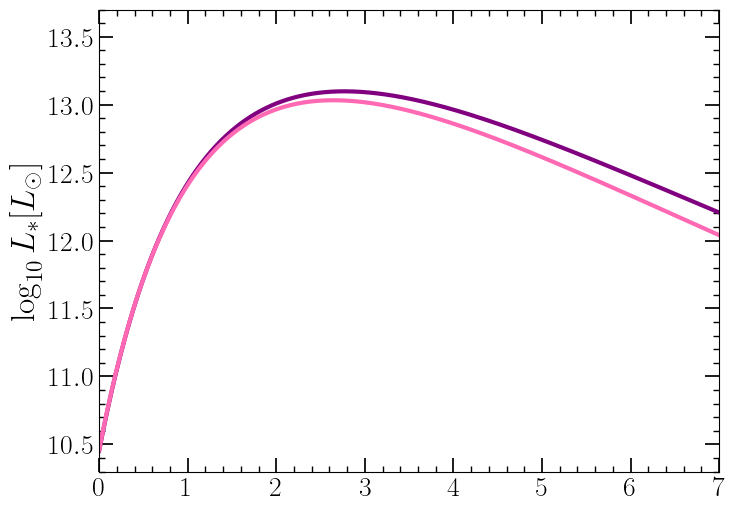

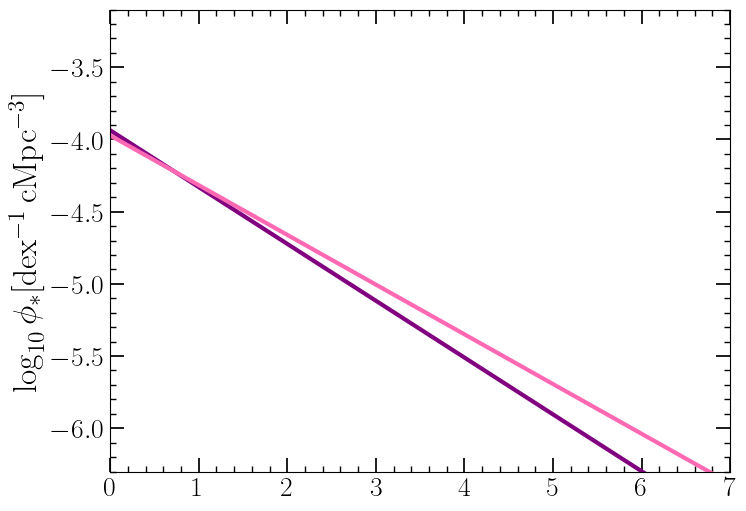

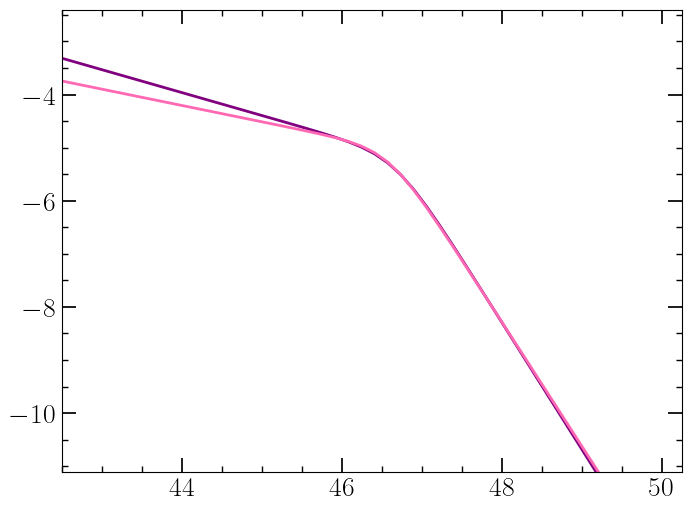

In [56]:
COEFFICIENTS_A = {
    'gamma_1': np.array([
                [0.8569, +0.0247, -0.0253],  # a0
                [-0.2614, +0.0162, -0.0164],  # a1
                [0.0200, +0.0011, -0.0011]  # a2
    ]),

    'gamma_2': np.array([
                [2.5375, +0.0177, -0.0187],  # b0
                [-1.0425, +0.0164, -0.0182],  # b1
                [1.1201, +0.0199, -0.0207]  # b2
    ]),

    'log10_L_star': np.array([
                [13.0088, +0.0090, -0.0091],  # c0
                [-0.5759, +0.0018, -0.0020],  # c1
                [0.4554, +0.0028, -0.0027]  # c2
    ]),

    'log10_phi_star': np.array([
                [-3.5426, +0.0235, -0.0209],  # d0
                [-0.3936, +0.0070, -0.0073]  # d1
    ]),
}

COEFFICIENTS_B = {
    'gamma_1': np.array([
                [0.3653, +0.0115, -0.0114],  # a0
                [-0.6006, +0.0422, -0.0417],  # a1
    ]),

    'gamma_2': np.array([
                [2.4709, +0.0163, -0.0169],  # b0
                [-0.9963, +0.0167, -0.0161],  # b1
                [1.0716, +0.0180, -0.0181]  # b2
    ]),

    'log10_L_star': np.array([
                [12.9656, +0.0092, -0.0089],  # c0
                [-0.5758, +0.0020, -0.0019],  # c1
                [0.4698, +0.0025, -0.0026]  # c2
    ]),

    'log10_phi_star': np.array([
                [-3.6276, +0.0209, -0.0203],  # d0
                [-0.3444, +0.0063, -0.0061]  # d1
    ]),
}


def gamma_1_zevo(z, model='A'):
    if model=='A':
        coefficients = COEFFICIENTS_A

        a0, a1, a2 = coefficients['gamma_1'][:,0]
        gamma_1 = a0 * chebyt(0)(1 + z) + a1 * chebyt(1)(1 + z) + a2 * chebyt(2)(1 + z)

    elif model=='B':
        coefficients = COEFFICIENTS_B

        z_ref = 2  # Choice by Shen et al.
        a0, a1 = coefficients['gamma_1'][:,0]
        gamma_1 = np.log10(a0) + a1 * np.log10((1 + z) / (1 + z_ref))
        gamma_1 = 10**gamma_1
    
    else:
        sys.exit(f'Unrecognized model, got: {model}')

    return gamma_1


def gamma_2_zevo(z, model='A'):
    if model=='A':
        coefficients = COEFFICIENTS_A
    elif model=='B':
        coefficients = COEFFICIENTS_B
    else:
        sys.exit(f'Unrecognized model, got: {model}')

    z_ref = 2  # Choice by Shen et al.
    b0, b1, b2 = coefficients['gamma_2'][:,0]
    log10_numerator = np.log10(2 * b0)
    denominator_log10_term1 = b1 * np.log10((1 + z) / (1 + z_ref))
    denominator_log10_term2 = b2 * np.log10((1 + z) / (1 + z_ref))
    log10_denominator = log10addexp10(denominator_log10_term1, denominator_log10_term2)
    return 10**(log10_numerator - log10_denominator)


def log10_L_star_zevo(z, model='A'):
    if model=='A':
        coefficients = COEFFICIENTS_A
    elif model=='B':
        coefficients = COEFFICIENTS_B
    else:
        sys.exit(f'Unrecognized model, got: {model}')
    
    z_ref = 2  # Choice by Shen et al.
    c0, c1, c2 = coefficients['log10_L_star'][:,0]
    log10_numerator = np.log10(2 * c0)
    denominator_log10_term1 = c1 * np.log10((1 + z) / (1 + z_ref))
    denominator_log10_term2 = c2 * np.log10((1 + z) / (1 + z_ref))
    log10_denominator = log10addexp10(denominator_log10_term1, denominator_log10_term2)
    return 10**(log10_numerator - log10_denominator)


def log10_phi_star_zevo(z, model='A'):
    if model=='A':
        coefficients = COEFFICIENTS_A
    elif model=='B':
        coefficients = COEFFICIENTS_B
    else:
        sys.exit(f'Unrecognized model, got: {model}')

    d0, d1 = coefficients['log10_phi_star'][:,0]
    log10_phi_star = d0 * chebyt(0)(1 + z) + d1 * chebyt(1)(1 + z)
    return log10_phi_star


def log10_QLF_shen(log10_L_sollum, z, model='A'):
    """
    log10_L: log10 bolometric luminosity [Lsun]
    log10_phi_star: log base 10 of amplitude [dex^-1 cMpc^-3]
    L_star: break luminosity [Lsun]
    gamma_1: faint-end slope
    gamma_2: bright-end slope
    """
    log10_phi_star = log10_phi_star_zevo(z, model)
    log10_L_star = log10_L_star_zevo(z, model)
    gamma_1 = gamma_1_zevo(z, model)
    gamma_2 = gamma_2_zevo(z, model)

    log10_term1 = gamma_1 * (log10_L_sollum - log10_L_star)
    log10_term2 = gamma_2 * (log10_L_sollum - log10_L_star)

    return log10_phi_star - log10addexp10(log10_term1, log10_term2)

zz = np.linspace(0, 7, 1000)
plt.figure(figsize=(8,6))
plt.plot(zz, gamma_1_zevo(zz, model='A'), color='purple', linewidth=3)
plt.plot(zz, gamma_1_zevo(zz, model='B'), color='hotpink', linewidth=3)
plt.xlim(0, 7)
plt.ylim(-0.1, 1.7)
plt.ylabel('Faint-end slope')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(zz, gamma_2_zevo(zz, model='A'), color='purple', linewidth=3)
plt.plot(zz, gamma_2_zevo(zz, model='B'), color='hotpink', linewidth=3)
plt.xlim(0, 7)
plt.ylim(0.9, 2.9)
plt.ylabel('Bright-end slope')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(zz, log10_L_star_zevo(zz, model='A'), color='purple', linewidth=3)
plt.plot(zz, log10_L_star_zevo(zz, model='B'), color='hotpink', linewidth=3)
plt.xlim(0, 7)
plt.ylim(10.3, 13.7)
plt.ylabel(r'$\log_{10} L_{*} [L_{\odot}]$')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(zz, log10_phi_star_zevo(zz, model='A'), color='purple', linewidth=3)
plt.plot(zz, log10_phi_star_zevo(zz, model='B'), color='hotpink', linewidth=3)
plt.xlim(0, 7)
plt.ylim(-6.3, -3.1)
plt.ylabel(r'$\log_{10} \phi_{*} [\mathrm{dex^{-1} \, cMpc^{-3}}]$')
plt.show()

LL = np.geomspace(1e42, 1e50) * u.erg / u.s
log10_LL_sollum = np.log10( LL.to(u.Lsun).value )

zfid = 3

plt.figure(figsize=(8,6))
plt.plot(np.log10(LL.value), log10_QLF_shen(log10_LL_sollum, z=zfid, model='A'), color='purple', linewidth=2)
plt.plot(np.log10(LL.value), log10_QLF_shen(log10_LL_sollum, z=zfid, model='B'), color='hotpink', linewidth=2)
# plt.semilogx()
plt.xlim(42.5, 50.25)
plt.ylim(-11.1, -2.4)
# plt.xticks([])
plt.show()


# Kulkarni et al. (2019)

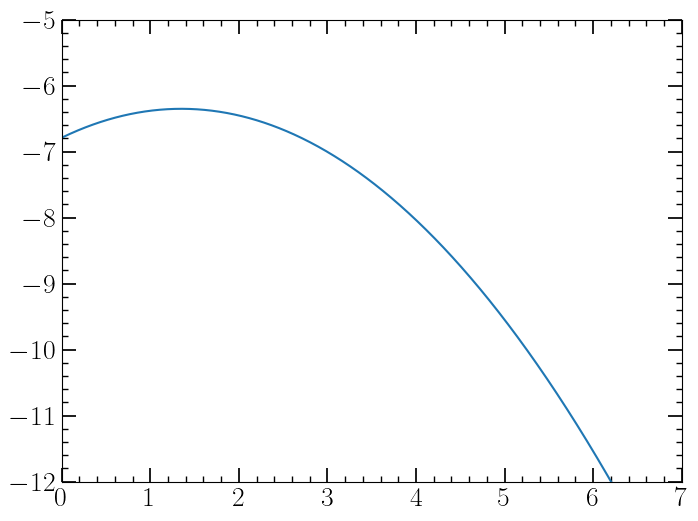

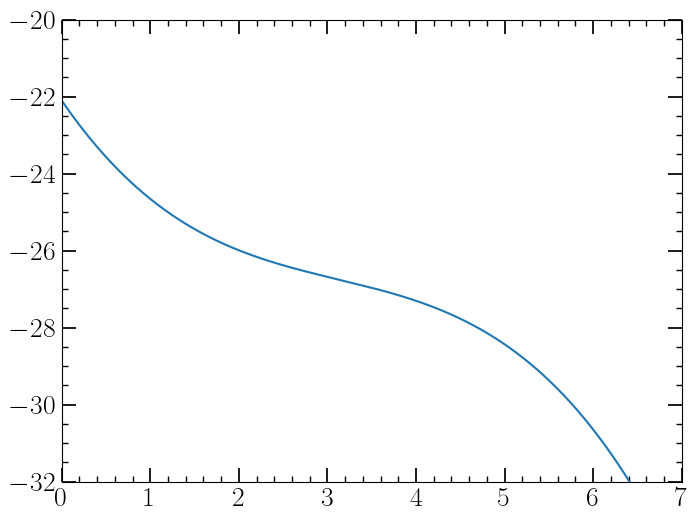

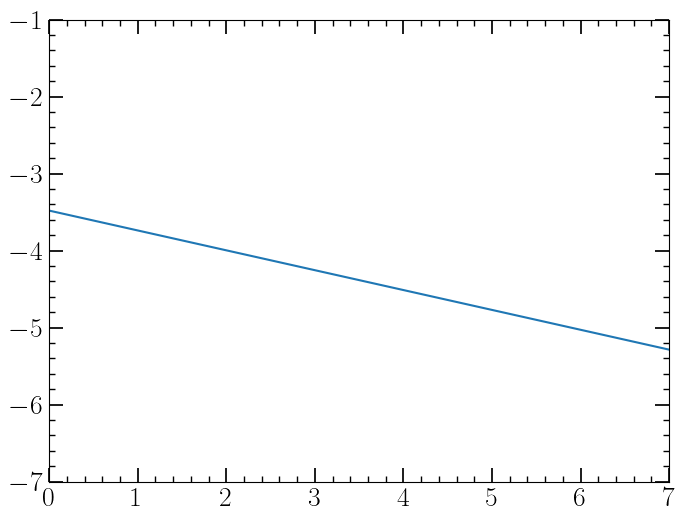

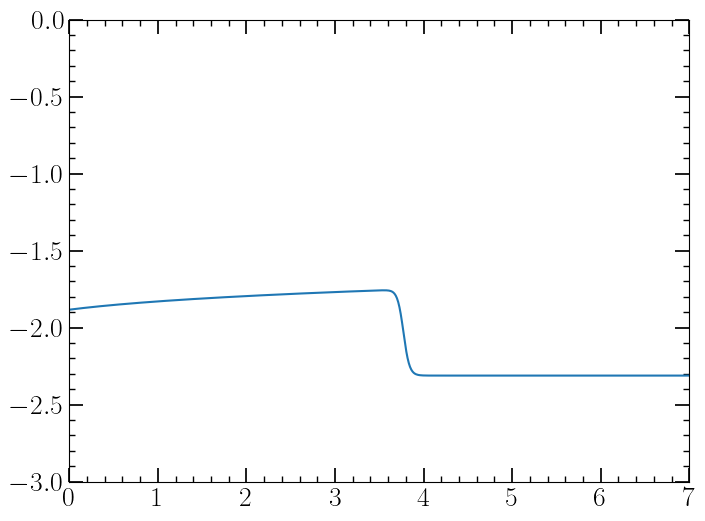

In [57]:
COEFFICIENTS = {
    0: np.array([
        [-7.798, +0.145, -0.157],  # c0,0
        [ 1.128, +0.085, -0.081],  # c0,1
        [-0.120, +0.005, -0.006],  # c0,2
    ]),
    
    1: np.array([
        [-17.163, +0.219, -0.226],   # c1,0
        [ -5.512, +0.127, -0.124],   # c1,1
        [  0.593, +0.011, -0.010],   # c1,2
        [ -0.024, +0.00035, -0.00039], # c1,3
    ]),
    
    2: np.array([
        [ -3.223, +0.127, -0.121],   # c2,0
        [ -0.258, +0.047, -0.051],   # c2,1
    ]),
    
    3: np.array([
        [ -2.312, +0.034, -0.032],   # c3,0
        [  0.559, +0.049, -0.045],   # c3,1
        [  3.773, +0.017, -0.016],   # c3,2
        [141.884, +31.521, -3.832],  # c3,3
        [ -0.171, +0.101, -0.116],   # c3,4
    ])
}


# def QLF(M, phi_star, M_star, alpha, beta):
#     """
#     M: absolute magnitude
#     phi_star: amplitude
#     M_star: break magnitude
#     alpha: bright-end slope
#     beta: faint-end slope
#     """
#     return phi_star / (10**(0.4 * (alpha + 1) * (M - M_star)) + 10**(0.4 * (beta + 1) * (M - M_star)))


def F(i, z):
    z = np.atleast_1d(z)
    x = 1 + z
    ci = COEFFICIENTS[i][:,0]
    
    if i != 3:
        Fi_x = np.zeros_like(z)
        for j, cij in enumerate(ci):
            Fi_x += cij * chebyt(j)(x)
        return Fi_x
    
    else:
        c30, c31, c32, c33, c34 = ci
        zeta = np.log10( x / (1 + c32) )
        return c30 + c31 / (10**(c33 * zeta) + 10**(c34 * zeta))


def log10_phi_star_zevo_kulkarni(z):
    return F(0, z)


def M_star_zevo(z):
    return F(1, z)


def alpha_zevo(z):
    return F(2, z)


def beta_zevo(z):
    return F(3, z)


def log10_QLF_kulkarni(M, z):
    """
    M: absolute magnitude
    log10_phi_star: log base 10 of amplitude [mag^-1 cMpc^-3]
    M_star: break magnitude
    alpha: bright-end slope
    beta: faint-end slope
    """
    log10_phi_star = log10_phi_star_zevo_kulkarni(z)
    M_star = M_star_zevo(z)
    alpha = alpha_zevo(z)
    beta = beta_zevo(z)

    term1 = 0.4 * (alpha + 1) * (M - M_star)
    term2 = 0.4 * (beta + 1) * (M - M_star)
    return log10_phi_star - log10addexp10(term1, term2)


# z_eval = 0.72 # 0.31#
# plt.figure()
# # plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-5.72), M_star=-21.30, alpha=-2.74, beta=-1.07) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-6.57), M_star=-24.21, alpha=-3.55, beta=-1.89) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), log10_QLF_kulkarni(np.linspace(-30, 0, 1000), z=z_eval), label='All z')
# plt.legend()
# plt.show()

z_ax = np.linspace(0, 7, 1000)
plt.figure(figsize=(8,6))
plt.plot(z_ax, log10_phi_star_zevo_kulkarni(z_ax))
plt.xlim(0, 7)
plt.ylim(-12, -5)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, M_star_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-32, -20)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, alpha_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-7, -1)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, beta_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-3, 0)
plt.show()


# Generate AGN priors

In [59]:
AGN_DIST_DIR = '/home/lucas/Documents/PhD/darksirenpop/agn_distribution'

L_threshes = [44.5, 45.0, 45.5, 46.0, 46.5]
zmin = 1e-4
zmax = 7
redshift_bin_edges = np.linspace(zmin, zmax, 1024+2)
redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2

for QLF in ['shenA', 'shenB', 'kulkarni']:
    for i, L_thresh in enumerate(L_threshes):

        # Step 1: Get number densities by integrating QLF over magnitude
        if QLF == 'shenA':
            log10_L_thresh_solmass = np.log10( (10**L_thresh * u.erg / u.s).to(u.Lsun).value )
            lum_integrate_axis = np.linspace(log10_L_thresh_solmass, 100, int(1024)+1)
            n_of_z = lambda z: romb(10**log10_QLF_shen(lum_integrate_axis[:,np.newaxis], z=z[np.newaxis,:], model='A'), dx=np.diff(lum_integrate_axis)[0], axis=0)

        elif QLF == 'shenB':
            log10_L_thresh_solmass = np.log10( (10**L_thresh * u.erg / u.s).to(u.Lsun).value )
            lum_integrate_axis = np.linspace(log10_L_thresh_solmass, 100, int(1024)+1)
            n_of_z = lambda z: romb(10**log10_QLF_shen(lum_integrate_axis[:,np.newaxis], z=z[np.newaxis,:], model='B'), dx=np.diff(lum_integrate_axis)[0], axis=0)

        elif QLF == 'kulkarni':
            magthresh = L2M(L_thresh)
            mag_integrate_axis = np.linspace(-100, magthresh, int(1024)+1)
            n_of_z = lambda z: romb(10**log10_QLF_kulkarni(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)
        
        else:
            sys.exit(f'Do not recognize QLF: {QLF}')

        numdenses = n_of_z(redshift_bin_edges).flatten()

        # Step 2: Get redshift distribution by integrating QLF in redshift bins
        n_agn_in_zbin = np.zeros_like(redshift_bin_centers)
        for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
            zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
            z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

            numdens_in_bin = n_of_z(z_integrate_ax)
            n_agn_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])

        # Step 3: Get redshift PDFs by normalizing
        agn_redshift_pdf = n_agn_in_zbin / romb(n_agn_in_zbin, dx=np.diff(redshift_bin_centers)[0])

        # np.save(f'{AGN_DIST_DIR}/agn_redshift_pdf_{L_thresh}_{QLF}', np.array([redshift_bin_centers, agn_redshift_pdf]))


0it [00:00, ?it/s]

1025it [00:01, 713.69it/s]
1025it [00:01, 711.97it/s]
1025it [00:01, 714.39it/s]
1025it [00:01, 707.65it/s]
1025it [00:01, 709.58it/s]
1025it [00:01, 740.66it/s]
1025it [00:01, 745.34it/s]
1025it [00:01, 746.90it/s]
1025it [00:01, 744.40it/s]
1025it [00:01, 740.78it/s]
1025it [00:01, 675.80it/s]
1025it [00:01, 673.67it/s]
1025it [00:01, 679.14it/s]
1025it [00:01, 680.06it/s]
1025it [00:01, 678.86it/s]


# Generate AGN posteriors

In [60]:
VERBOSE = True

AGN_DIST_DIR = '/home/lucas/Documents/PhD/darksirenpop/agn_distribution'

ZMIN = 1e-4  # Some buffer for astropy's lowest possible value
ZMAX = 7.   # Maximum true redshift for GWs, such that p_rate(z > ZMAX) = 0
AGN_ZMAX = 7.
AGN_COMDIST_MAX = COSMO.comoving_distance(AGN_ZMAX).value

AGN_ZPRIOR = '44.5'

Z_INTEGRAL_AX = np.linspace(ZMIN, ZMAX, int(512)+1)  # Sets the resolution of the redshift prior, should capture all information of AGN posteriors, see Gray et al. 2022, 2023
ASSUME_PERFECT_REDSHIFT = False
AGN_ZERROR = 'quaia'
if AGN_ZERROR == 'quaia':
    quaia_errors = pd.read_csv("/home/lucas/Documents/PhD/Quaia_z15.csv")["redshift_quaia_err"]  # Load into memory and sample later
    

def get_agn_zprior():
    """
    'positive_redshift', 'uniform_comoving_volume', '44.5_<QLF>', '45.0_<QLF>', '45.5_<QLF>', '46.0_<QLF>', '46.5_<QLF>'
    """

    if AGN_ZPRIOR == 'uniform_comoving_volume':
        return lambda z: uniform_comoving_prior(z)
    
    elif str(AGN_ZPRIOR)[:4] in ['44.5', '45.0', '45.5', '46.0', '46.5']:
        filename = f'{AGN_DIST_DIR}/agn_redshift_pdf_{AGN_ZPRIOR}.npy'
        if VERBOSE:
            print(f'Loading AGN redshift distribution calculated from QLF from file: {filename}')
        z, n = np.load(filename)
        return interp1d(z, n, bounds_error=False, fill_value=0)
    
    elif AGN_ZPRIOR == 'positive_redshift':  # Equivalent to a uniform-in-redshift prior. Redundant since the Z_INTEGRAL_AX is >0, but this way we enforce a conscious decision on the prior.
        return lambda z: z_cut(-z, zcut=0)
    
    else:
        sys.exit(f'AGN redshift prior not recognized: {AGN_ZPRIOR}. \nExiting...')


def get_agn_z_posterior_norm_ax(at_least_N=10):
    if AGN_ZERROR == 'quaia':
        smallest_error = np.min(quaia_errors)
    else:
        smallest_error = AGN_ZERROR
    npoints = int(2**np.ceil(np.log2(at_least_N * (AGN_ZMAX - ZMIN) / smallest_error)))  # Enforces at least N points within 1 sigma in normalization of AGN posteriors
    return np.linspace(ZMIN, AGN_ZMAX, npoints + 1)


AGN_ZPRIOR_FUNCTION = get_agn_zprior()

if not ASSUME_PERFECT_REDSHIFT:
    AGN_POSTERIOR_NORM_AX = get_agn_z_posterior_norm_ax()


def compute_and_save_posteriors_hdf5(filename, all_agn_z, all_agn_z_err):
    '''
    AGN redshift posteriors are modelled as truncnorms on [0, inf) with a uniform-in-comoving-volume redshift prior.
    The posteriors are normalized on agn_posterior_norm_ax, which goes up to AGN_ZMAX.
    The posteriors are then evaluated on Z_INTEGRAL_AX, which is what is necessary for the crossmatch.
    '''

    maxdiff = np.max(np.diff(AGN_POSTERIOR_NORM_AX))
    thresh = np.min(all_agn_z_err) / 10
    assert maxdiff < thresh, f'AGN normalization array is too coarse to capture AGN distribution fully. Got {maxdiff:.3e}, need {thresh:.3e}.'

    n_agn = len(all_agn_z)
    n_z = len(Z_INTEGRAL_AX)  # Only need to save the posterior evaluated at this axis
    chunk_size = int(1e6 / n_z)
    dx = np.diff(AGN_POSTERIOR_NORM_AX)[0]  # For romb integration on linear axis
    with h5py.File(filename, "w") as f:
        dset = f.create_dataset("agn_redshift_posteriors", shape=(n_agn, n_z), dtype=np.float64)

        if VERBOSE:
            iterchunks = tqdm( range(0, n_agn, chunk_size) )
        else:
            iterchunks = range(0, n_agn, chunk_size)

        for start in iterchunks:
            end = min(start + chunk_size, n_agn)

            z_chunk = all_agn_z[start:end]
            zerr_chunk = all_agn_z_err[start:end]

            likelihood = lambda z: stats.truncnorm.pdf(
                z,
                a=(ZMIN - z_chunk[:, None]) / zerr_chunk[:, None],
                b=(np.inf - z_chunk[:, None]) / zerr_chunk[:, None],
                loc=z_chunk[:, None],
                scale=zerr_chunk[:, None]
            )

            agn_posteriors_unnorm = lambda z: likelihood(z) * z_cut(z, zcut=AGN_ZMAX) * AGN_ZPRIOR_FUNCTION(z)
            z_norms = romb(agn_posteriors_unnorm(AGN_POSTERIOR_NORM_AX), dx=dx)
            posteriors = agn_posteriors_unnorm(Z_INTEGRAL_AX) / z_norms[:, None]  # Save the posterior evaluated at the relevant axis

            dset[start:end, :] = posteriors
    if VERBOSE:
        print(f"All AGN posteriors written to {filename}")
    return


Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5.npy


In [61]:
CATALOG_PATH = "/home/lucas/Documents/PhD/Quaia_z15.csv"

for QLF in ['shenA', 'shenB', 'kulkarni']:

    for thresh in L_threshes:

        df = pd.read_csv(CATALOG_PATH)
        cols = ["redshift_quaia", "redshift_quaia_err", "ra", "dec", "b", "loglbol_corr"]
        data = df[cols]
        b              = data["b"].to_numpy()
        loglbol_corr   = data["loglbol_corr"].to_numpy()
        outside_galactic_plane = np.logical_or((b > 10), (b < -10))
        above_lbol_thresh = loglbol_corr >= float(thresh)

        agn_redshift       = data["redshift_quaia"].to_numpy()[outside_galactic_plane & above_lbol_thresh]
        agn_redshift_err   = data["redshift_quaia_err"].to_numpy()[outside_galactic_plane & above_lbol_thresh]

        filename = f'./quaia_testing_{thresh}_{QLF}.hdf5'

        AGN_ZPRIOR = f'{thresh}_{QLF}'
        AGN_ZPRIOR_FUNCTION = get_agn_zprior()
        # compute_and_save_posteriors_hdf5(filename, agn_redshift, agn_redshift_err)


Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.0_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.5_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.0_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.5_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5_shenB.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Docum

179916


100%|██████████| 1000/1000 [00:08<00:00, 114.73it/s]


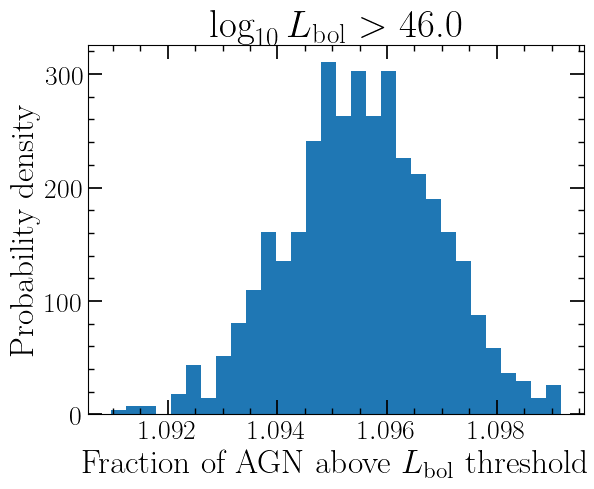

In [62]:
err = 0.2
N = int(1e3)
l = 46.0

for QLF in ['kulkarni']:  # 'shenA', 'shenB', 

    for thresh in [l]:

        df = pd.read_csv(CATALOG_PATH)
        cols = ["redshift_quaia", "redshift_quaia_err", "ra", "dec", "b", "loglbol_corr"]
        data = df[cols]
        b              = data["b"].to_numpy()
        loglbol_corr   = data["loglbol_corr"].to_numpy()

        baseline = np.sum(loglbol_corr >= float(thresh))
        print(baseline)
        
        N_above_thresh = np.zeros(N)
        for i in tqdm(range(N)):
            loglbol_corr_meas = np.random.normal(loglbol_corr, scale=err)
            # plt.figure()
            # plt.hist(loglbol_corr_meas, bins=30)
            # plt.vlines(thresh, 0, 2e5, color='black')
            # plt.show()
            
            N_above_thresh[i] = np.sum(loglbol_corr_meas >= float(thresh))
            # print(N_above_thresh[i], N_above_thresh[i] / baseline)
            # sys.exit(1)

plt.figure()
plt.hist(N_above_thresh / baseline, bins=30, density=True)
plt.xlabel(r'Fraction of AGN above $L_{\rm bol}$ threshold')
plt.ylabel('Probability density')
plt.title(r'$\log_{10} L_{\rm bol} >$ ' + str(l))
plt.show()


Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.0_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.5_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.0_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.5_shenA.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5_shenB.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Docum

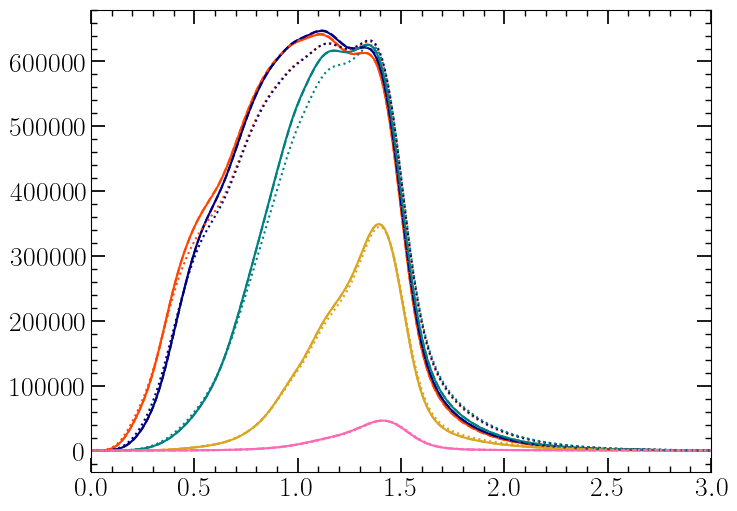

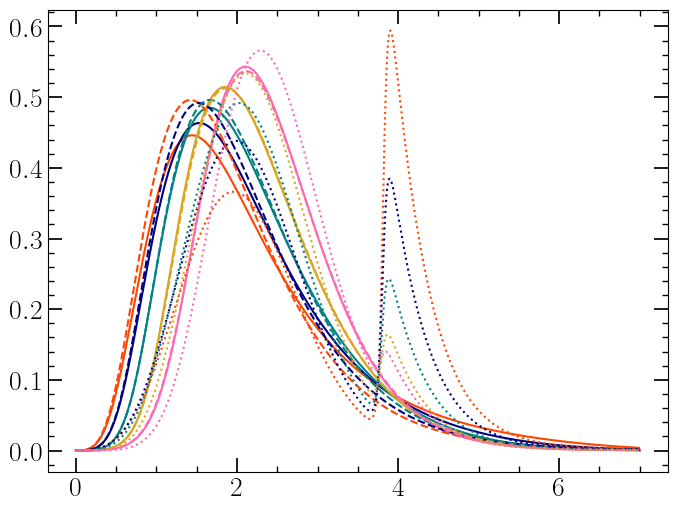

In [63]:
def get_SoP(L_threshes, QLF, dir='./quaia_testing'):
    '''
    Get sums of posteriors for luminosity thresholds and specified QLF
    '''

    SoPs = []
    for L_thresh in L_threshes:
        filename = f'{dir}_{L_thresh}_{QLF}.hdf5'
        with h5py.File(filename, "r") as f:
            agn_posterior_dset = f["agn_redshift_posteriors"][()]
        SoPs.append(np.sum(agn_posterior_dset, axis=0))
    return SoPs


fig1, ax1 = plt.subplots(figsize=(8,6))
fig2, ax2 = plt.subplots(figsize=(8,6))

for QLF in ['shenA', 'shenB', 'kulkarni']:

    if QLF == 'shenA':
        linestyle = 'solid'
        label = 'Shen+2020 A'
    elif QLF == 'shenB':
        linestyle = 'dashed'
        label = 'Shen+2020 B'
    elif QLF == 'kulkarni':
        linestyle = 'dotted'
        label = 'Kulkarni+2019'
    else:
        sys.exit(f'Do not recognize QLF: {QLF}')

    SoP44_5, SoP45_0, SoP45_5, SoP46_0, SoP46_5 = get_SoP(L_threshes, QLF)
    
    for i, SoP in enumerate([SoP44_5, SoP45_0, SoP45_5, SoP46_0, SoP46_5]):
        ax1.plot(Z_INTEGRAL_AX, SoP, color=COLORS[i], linestyle=linestyle)

    for i, thresh in enumerate(L_threshes):
        AGN_ZPRIOR = f'{thresh}_{QLF}'
        AGN_ZPRIOR_FUNCTION = get_agn_zprior()
        ax2.plot(np.linspace(1e-4, 7, 1000), AGN_ZPRIOR_FUNCTION(np.linspace(1e-4, 7, 1000)), color=COLORS[i], linestyle=linestyle)

ax1.set_xlim(0, 3)
# ax1.semilogy()
plt.show()


# Plot results

In [64]:
def obs_numdens_of_z(z, sum_of_posteriors):
    observed_sky_fraction = 1 - np.sin(np.deg2rad(10))
    n = sum_of_posteriors / (4 * np.pi * COSMO.differential_comoving_volume(Z_INTEGRAL_AX).value) / observed_sky_fraction
    return interp1d(x=Z_INTEGRAL_AX, y=n, bounds_error=False, fill_value=0)(z)


AGN_ZCUT = 1.5
THRESHOLD_MAP = {"46.5": 0, "46.0": 1, "45.5": 2, "45.0": 3, "44.5": 4}
V25_zedges = np.array([0.0000, 0.1875, 0.3750, 0.5625, 0.7500, 0.9375, 1.1250, 1.3125, AGN_ZCUT, AGN_ZMAX])
QUAIA_C_VALS = np.array([
                    [0.000, 0.000, 0.229, 0.945, 0.718],
                    [1.000, 1.000, 1.000, 1.000, 0.781],
                    [1.000, 1.000, 1.000, 1.000, 0.408],
                    [1.000, 0.891, 1.000, 0.681, 0.211],
                    [1.000, 1.000, 0.994, 0.429, 0.138],
                    [1.000, 1.000, 0.837, 0.258, 0.085],
                    [0.927, 0.940, 0.576, 0.179, 0.060],
                    [1.000, 1.000, 0.482, 0.155, 0.053],
                    [0., 0., 0., 0., 0.]])
def redshift_completeness(z, completeness_zedges, completeness_zvals):
    bin_idx = np.digitize(z, completeness_zedges) - 1
    bin_idx[bin_idx == len(completeness_zvals)] = len(completeness_zvals) - 1
    return completeness_zvals[bin_idx.astype(np.int32)]


def make_qlf_plots(axs, QLF, L_thresh, redshift_bin_edges, redshift_bin_centers, color):
    ax1, ax2, ax3 = axs

    # Step 1: Get number densities by integrating QLF over Lbol or M
    if QLF == 'shenA':
        log10_L_thresh_solmass = np.log10( (10**L_thresh * u.erg / u.s).to(u.Lsun).value )
        lum_integrate_axis = np.linspace(log10_L_thresh_solmass, 100, int(1024)+1)
        n_of_z = lambda z: romb(10**log10_QLF_shen(lum_integrate_axis[:,np.newaxis], z=z[np.newaxis,:], model='A'), dx=np.diff(lum_integrate_axis)[0], axis=0)

        linestyle = 'solid'
        label = 'Shen+2020 A QLF (This work)'

    elif QLF == 'shenB':
        log10_L_thresh_solmass = np.log10( (10**L_thresh * u.erg / u.s).to(u.Lsun).value )
        lum_integrate_axis = np.linspace(log10_L_thresh_solmass, 100, int(1024)+1)
        n_of_z = lambda z: romb(10**log10_QLF_shen(lum_integrate_axis[:,np.newaxis], z=z[np.newaxis,:], model='B'), dx=np.diff(lum_integrate_axis)[0], axis=0)

        linestyle = 'dashed'
        label = 'Shen+2020 B QLF (This work)'

    elif QLF == 'kulkarni':
        magthresh = L2M(L_thresh)
        mag_integrate_axis = np.linspace(-100, magthresh, int(1024)+1)
        n_of_z = lambda z: romb(10**log10_QLF_kulkarni(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)

        linestyle = 'dotted'
        label = 'Kulkarni+2019 QLF (This work)'
    
    else:
        sys.exit(f'Do not recognize QLF: {QLF}')


    qlf_numdenses = n_of_z(redshift_bin_centers).flatten()
    
    sum_of_posteriors = get_SoP(np.atleast_1d(L_thresh), QLF)[0]
    obs_numdenses = obs_numdens_of_z(redshift_bin_centers, sum_of_posteriors)
    
    ax1.plot(redshift_bin_centers, qlf_numdenses, color=color, linewidth=2, linestyle=linestyle)
    ax1.plot(redshift_bin_centers, obs_numdenses, color='black', linewidth=2, linestyle=linestyle, label='Observed')

    # Step 2: Get redshift distribution by integrating QLF in redshift bins
    n_agn_in_zbin = np.zeros_like(redshift_bin_centers)
    for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
        zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
        z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

        numdens_in_bin = n_of_z(z_integrate_ax)
        n_agn_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])
    # ax.plot(redshift_bin_centers, n_agn_in_zbin, color=color, linestyle=linestyle)  # , label=r'$\log_{10} L_{\rm bol} >$ ' + str(L_thresh)

    # Step 3: Get redshift PDFs by normalizing
    agn_redshift_pdf = n_agn_in_zbin / romb(n_agn_in_zbin, dx=np.diff(redshift_bin_centers)[0])
    ax2.plot(redshift_bin_centers, agn_redshift_pdf, color=color, linewidth=2, linestyle=linestyle)

    # Step 4: Plot completenesses
    fc_of_z = obs_numdenses / qlf_numdenses
    ax3.plot(redshift_bin_centers, fc_of_z, color=color, linewidth=2, linestyle=linestyle, label=label)

    # np.save(f'{AGN_DIST_DIR}/completeness_{L_thresh}', np.array([redshift_bin_centers, fc_of_z]))

    return



1025it [00:01, 716.30it/s]
1025it [00:01, 750.21it/s]
1025it [00:01, 690.55it/s]
1025it [00:01, 725.50it/s]
1025it [00:01, 749.86it/s]
1025it [00:01, 686.31it/s]
1025it [00:01, 718.77it/s]
1025it [00:01, 752.75it/s]
1025it [00:01, 686.20it/s]
1025it [00:01, 722.10it/s]
1025it [00:01, 739.84it/s]
1025it [00:01, 686.02it/s]
1025it [00:01, 714.98it/s]
1025it [00:01, 746.00it/s]
1025it [00:01, 687.23it/s]


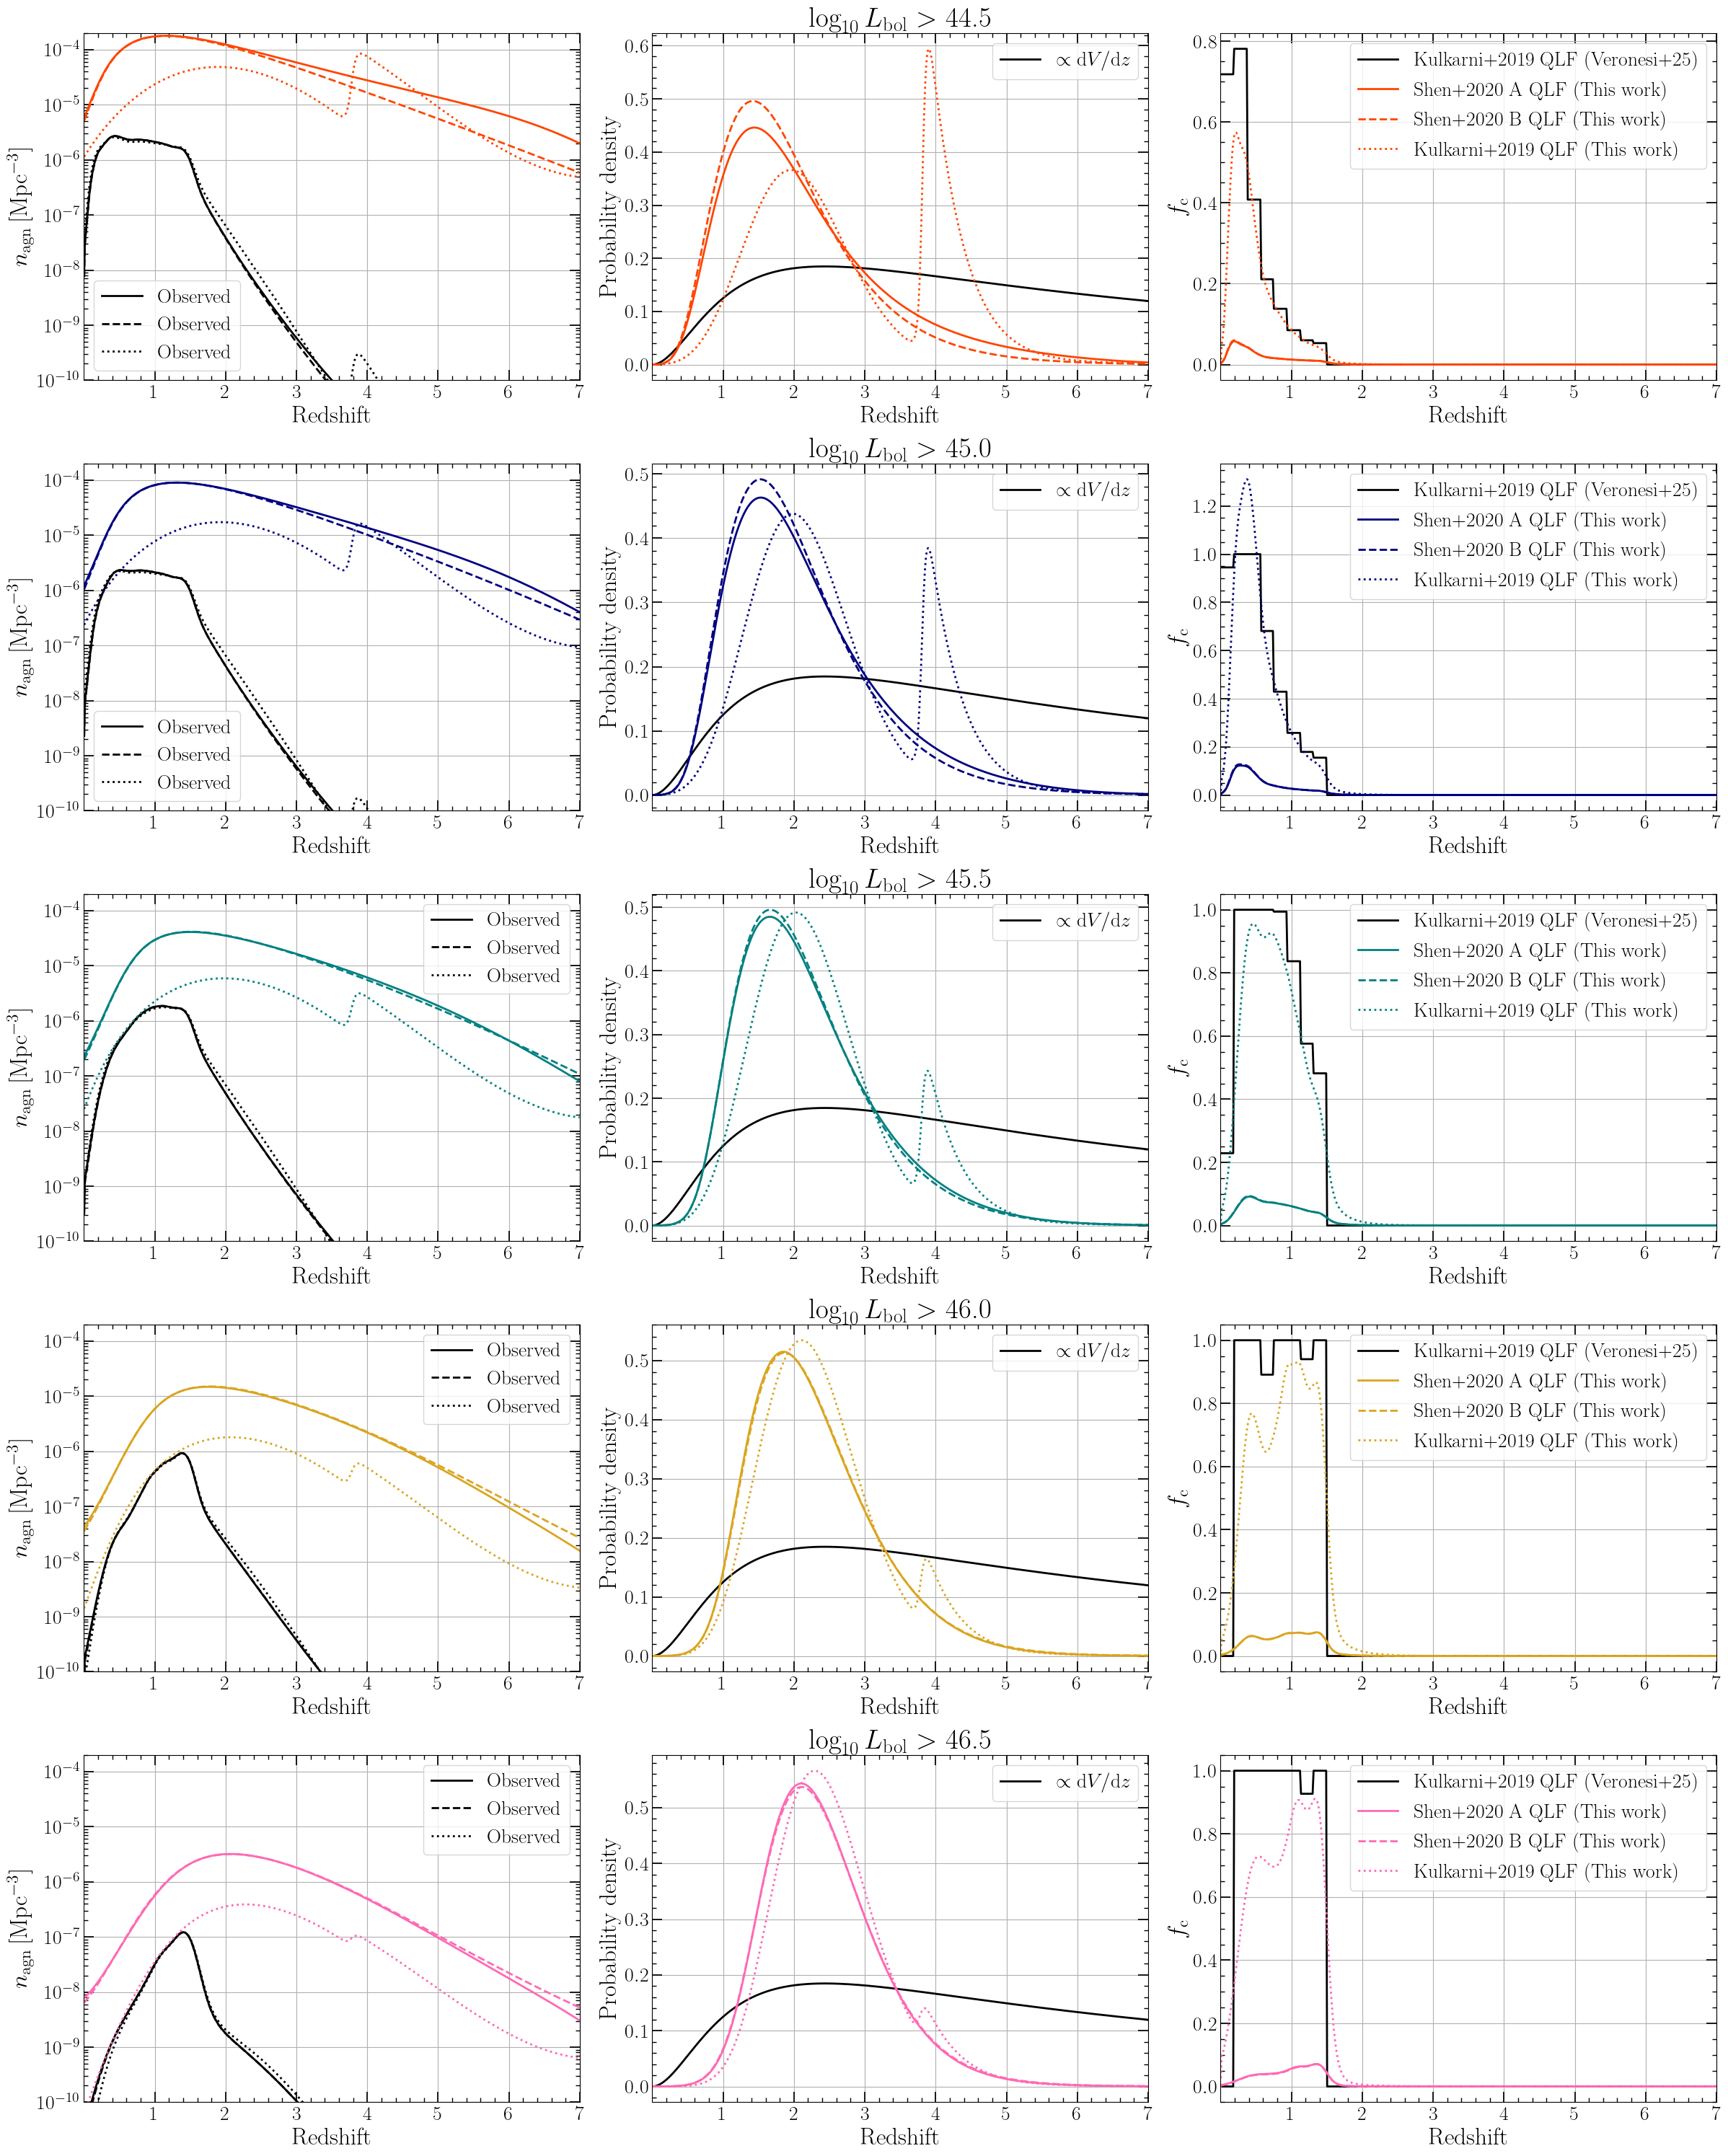

In [80]:
AGN_DIST_DIR = '/home/lucas/Documents/PhD/darksirenpop/agn_distribution'

L_threshes = [44.5, 45.0, 45.5, 46.0, 46.5]

zmin = 1e-4
zmax = 7
redshift_bin_edges = np.linspace(zmin, zmax, 1024+2)
redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2

fig, ax = plt.subplots(5, 3, figsize=(24,30))

for i, L_thresh in enumerate(L_threshes):

    ax1, ax2, ax3 = ax[i,:]

    ax1.semilogy()
    ax1.set_xlim(zmin, zmax)
    ax1.set_ylim(1e-10, 2e-4)  # ax1.set_ylim(1e-10, 2e-4)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
    ax1.grid()

    ax2.grid()
    ax2.set_xlim(zmin, zmax)
    ax2.set_xlabel('Redshift')
    ax2.set_ylabel('Probability density')
    ax2.plot(redshift_bin_centers, uniform_comoving_prior(redshift_bin_centers) / romb(uniform_comoving_prior(redshift_bin_centers), dx=np.diff(redshift_bin_centers)[0]), 
             label=r'$\propto \mathrm{d}V / \mathrm{d}z$', color='black', linewidth=2)

    ax3.grid()
    ax3.set_xlim(zmin, zmax)
    ax3.set_ylabel(r'$f_{\rm c}$')
    ax3.set_xlabel('Redshift')
    ax3.plot(Z_INTEGRAL_AX, redshift_completeness(Z_INTEGRAL_AX, V25_zedges, np.array(QUAIA_C_VALS[:, THRESHOLD_MAP[str(L_thresh)]])), linewidth=2, label=f'Kulkarni+2019 QLF (Veronesi+25)', color='black')

    make_qlf_plots([ax1, ax2, ax3], 'shenA', L_thresh, redshift_bin_edges, redshift_bin_centers, color=COLORS[i])
    make_qlf_plots([ax1, ax2, ax3], 'shenB', L_thresh, redshift_bin_edges, redshift_bin_centers, color=COLORS[i])
    make_qlf_plots([ax1, ax2, ax3], 'kulkarni', L_thresh, redshift_bin_edges, redshift_bin_centers, color=COLORS[i])

    ax2.set_title(r'$\log_{10} L_{\rm bol} >$ ' + str(L_thresh))
    ax1.legend()
    ax2.legend()
    ax3.legend()
plt.tight_layout()
plt.show()
    

0.2920789030706111 Gair


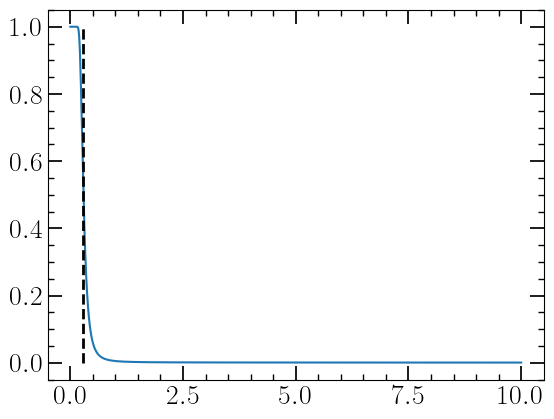

----- kulkarni -----
44.5


1025it [00:01, 674.61it/s]


0.004023707267688243 unif
0.0009198074226540139 qlf
4.374510542737556 RATIO

45.0


1025it [00:01, 675.32it/s]


0.004023707267688243 unif
0.001083035701664727 qlf
3.7152120299482547 RATIO

45.5


1025it [00:01, 683.14it/s]


0.004023707267688243 unif
0.0011629919955917039 qlf
3.459789304604003 RATIO

46.0


1025it [00:01, 680.13it/s]


0.004023707267688243 unif
0.0010937052786453305 qlf
3.678968499331035 RATIO

46.5


1025it [00:01, 684.20it/s]


0.004023707267688243 unif
0.0009416155573332587 qlf
4.27319539949377 RATIO

----- shenA -----
44.5


1025it [00:01, 716.65it/s]


0.004023707267688243 unif
0.0050882363786591035 qlf
0.7907862308764447 RATIO

45.0


1025it [00:01, 714.20it/s]


0.004023707267688243 unif
0.0035557671955432635 qlf
1.131600311947162 RATIO

45.5


1025it [00:01, 702.34it/s]


0.004023707267688243 unif
0.002436931937367188 qlf
1.6511364991323372 RATIO

46.0


1025it [00:01, 714.76it/s]


0.004023707267688243 unif
0.0017759749016744372 qlf
2.2656329568028144 RATIO

46.5


1025it [00:01, 715.06it/s]


0.004023707267688243 unif
0.0014472137403335529 qlf
2.780313063335663 RATIO

----- shenB -----
44.5


1025it [00:01, 749.30it/s]


0.004023707267688243 unif
0.005551859062010811 qlf
0.724749533939161 RATIO

45.0


1025it [00:01, 748.53it/s]


0.004023707267688243 unif
0.0036678226246035727 qlf
1.0970288586741936 RATIO

45.5


1025it [00:01, 738.10it/s]


0.004023707267688243 unif
0.0024362671342231064 qlf
1.651587057579115 RATIO

46.0


1025it [00:01, 741.61it/s]


0.004023707267688243 unif
0.00175710663138391 qlf
2.2899619156972513 RATIO

46.5


1025it [00:01, 742.85it/s]

0.004023707267688243 unif
0.0014460923773964318 qlf
2.782469039033724 RATIO



In [82]:
# Check detectable fractions - these should be added as correction factors

from astropy.cosmology import z_at_value
from scipy.special import erf

print( z_at_value(COSMO.luminosity_distance, 1550 * u.Mpc).value, 'Gair' )

DLTHRESH = 1550 * u.Mpc
RELERR = 0.3

def Pdet(z, gw_relerr, dlthresh=DLTHRESH):
    return 0.5 * (1 + erf((dlthresh - COSMO.luminosity_distance(z)) / (np.sqrt(2) * gw_relerr * COSMO.luminosity_distance(z))))

AGN_DIST_DIR = '/home/lucas/Documents/PhD/darksirenpop/agn_distribution'

L_threshes = [44.5, 45.0, 45.5, 46.0, 46.5]

zmin = 1e-4
zmax = 10

zz = np.linspace(zmin, zmax, 1024+1)
redshift_bin_edges = np.linspace(zmin, zmax, 1024+2)
redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2


plt.figure()
plt.plot(zz, Pdet(zz, gw_relerr=0.3))
plt.vlines(z_at_value(COSMO.luminosity_distance, DLTHRESH).value, 0, 1, linestyles='dashed', linewidth=2, color='black')
plt.show()


for QLF in ['kulkarni', 'shenA', 'shenB']:
    print(f'----- {QLF} -----')

    for i, L_thresh in enumerate(L_threshes):
        print(L_thresh)
        unif_comvol = uniform_comoving_prior(redshift_bin_centers) / romb(uniform_comoving_prior(redshift_bin_centers), dx=np.diff(redshift_bin_centers)[0])
        interp_unif_comvol = interp1d(redshift_bin_centers, unif_comvol, fill_value=0, bounds_error=False)


        if QLF == 'shenA':
            log10_L_thresh_solmass = np.log10( (10**L_thresh * u.erg / u.s).to(u.Lsun).value )
            lum_integrate_axis = np.linspace(log10_L_thresh_solmass, 100, int(1024)+1)
            n_of_z = lambda z: romb(10**log10_QLF_shen(lum_integrate_axis[:,np.newaxis], z=z[np.newaxis,:], model='A'), dx=np.diff(lum_integrate_axis)[0], axis=0)

        elif QLF == 'shenB':
            log10_L_thresh_solmass = np.log10( (10**L_thresh * u.erg / u.s).to(u.Lsun).value )
            lum_integrate_axis = np.linspace(log10_L_thresh_solmass, 100, int(1024)+1)
            n_of_z = lambda z: romb(10**log10_QLF_shen(lum_integrate_axis[:,np.newaxis], z=z[np.newaxis,:], model='B'), dx=np.diff(lum_integrate_axis)[0], axis=0)

        elif QLF == 'kulkarni':
            magthresh = L2M(L_thresh)
            mag_integrate_axis = np.linspace(-100, magthresh, int(1024)+1)
            n_of_z = lambda z: romb(10**log10_QLF_kulkarni(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)
        
        else:
            sys.exit(f'Do not recognize QLF: {QLF}')

        qlf_numdenses = n_of_z(redshift_bin_centers).flatten()
        
        sum_of_posteriors = get_SoP(np.atleast_1d(L_thresh), QLF)[0]
        obs_numdenses = obs_numdens_of_z(redshift_bin_centers, sum_of_posteriors)
    
        n_agn_in_zbin = np.zeros_like(redshift_bin_centers)
        for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
            zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
            z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

            numdens_in_bin = n_of_z(z_integrate_ax)
            n_agn_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])

        agn_redshift_pdf = n_agn_in_zbin / romb(n_agn_in_zbin, dx=np.diff(redshift_bin_centers)[0])
        interp_agn_zpdf = interp1d(redshift_bin_centers, agn_redshift_pdf, bounds_error=False, fill_value=0)
        
        unif_detectable = romb(Pdet(zz, gw_relerr=RELERR, dlthresh=DLTHRESH) * interp_unif_comvol(zz), dx=np.diff(zz)[0])
        qlf_detectable = romb(Pdet(zz, gw_relerr=RELERR, dlthresh=DLTHRESH) * interp_agn_zpdf(zz), dx=np.diff(zz)[0])

        # unif_undetectable = romb(interp_unif_comvol(zz_verify), dx=np.diff(zz_verify)[0])
        # qlf_undetectable = romb(interp_agn_zpdf(zz_verify), dx=np.diff(zz_verify)[0])
        print(unif_detectable, 'unif')
        print(qlf_detectable, 'qlf')
        print(unif_detectable / qlf_detectable, 'RATIO')
        # print(unif_detectable + unif_undetectable)
        # print(qlf_detectable + qlf_undetectable)
        print()



In [ ]:
# L_threshes = [44.5, 45.0, 45.5, 46.0, 46.5]
# sums_of_posteriors = [SoP44_5, SoP45_0, SoP45_5, SoP46_0, SoP46_5]

# zmin = 1e-4
# zmax = 3
# redshift_bin_edges = np.linspace(zmin, zmax, 1024+2)
# redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2


# def obs_numdens_of_z(z, sum_of_posteriors):
#     observed_sky_fraction = 1 - np.sin(np.deg2rad(10))
#     n = sum_of_posteriors / (4 * np.pi * COSMO.differential_comoving_volume(Z_INTEGRAL_AX).value) / observed_sky_fraction
#     return interp1d(x=Z_INTEGRAL_AX, y=n, bounds_error=False, fill_value=0)(z)


# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

# ax1.semilogy()
# ax1.set_xlim(zmin, zmax)
# ax1.set_ylim(1e-10, 2e-4)
# ax1.set_xlabel('Redshift')
# ax1.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
# ax1.grid()

# ax2.grid()
# ax2.semilogy()
# ax2.set_xlim(zmin, zmax)
# ax2.set_xlabel('Redshift')
# ax2.set_ylabel(r'$N_{\rm agn}$')

# ax3.grid()
# ax3.set_xlim(zmin, zmax)
# ax3.set_xlabel('Redshift')
# ax3.set_ylabel('Probability density')
# ax3.plot(redshift_bin_centers, uniform_comoving_prior(redshift_bin_centers) / romb(uniform_comoving_prior(redshift_bin_centers), dx=np.diff(redshift_bin_centers)[0]), label='Uniform', color='black', linewidth=2)

# AGN_ZCUT = 1.5
# THRESHOLD_MAP = {"46.5": 0, "46.0": 1, "45.5": 2, "45.0": 3, "44.5": 4}
# V25_zedges = np.array([0.0000, 0.1875, 0.3750, 0.5625, 0.7500, 0.9375, 1.1250, 1.3125, AGN_ZCUT, AGN_ZMAX])
# QUAIA_C_VALS = np.array([
#                     [0.000, 0.000, 0.229, 0.945, 0.718],
#                     [1.000, 1.000, 1.000, 1.000, 0.781],
#                     [1.000, 1.000, 1.000, 1.000, 0.408],
#                     [1.000, 0.891, 1.000, 0.681, 0.211],
#                     [1.000, 1.000, 0.994, 0.429, 0.138],
#                     [1.000, 1.000, 0.837, 0.258, 0.085],
#                     [0.927, 0.940, 0.576, 0.179, 0.060],
#                     [1.000, 1.000, 0.482, 0.155, 0.053],
#                     [0., 0., 0., 0., 0.]])
# def redshift_completeness(z, completeness_zedges, completeness_zvals):
#     bin_idx = np.digitize(z, completeness_zedges) - 1
#     bin_idx[bin_idx == len(completeness_zvals)] = len(completeness_zvals) - 1
#     return completeness_zvals[bin_idx.astype(np.int32)]

# ax4.grid()
# ax4.set_xlim(zmin, zmax)
# ax4.set_ylabel(r'$f_{\rm c}$')
# ax4.set_xlabel('Redshift')

# for i, (L_thresh, sum_of_posteriors) in enumerate(zip(L_threshes, sums_of_posteriors)):

#     # Step 1: Get number densities by integrating QLF over magnitude
#     magthresh = L2M(L_thresh)
#     mag_integrate_axis = np.linspace(-100, magthresh, int(1024)+1)
#     n_of_z = lambda z: romb(10**log10_QLF_kulkarni(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)
#     qlf_numdenses = n_of_z(redshift_bin_centers).flatten()
#     obs_numdenses = obs_numdens_of_z(redshift_bin_centers, sum_of_posteriors)
#     ax1.plot(redshift_bin_centers, qlf_numdenses, color=COLORS[i], linewidth=2)
#     ax1.plot(redshift_bin_centers, obs_numdenses, color=COLORS[i], linewidth=2, linestyle='dashed')

#     # Step 2: Get redshift distribution by integrating QLF in redshift bins
#     n_agn_in_zbin = np.zeros_like(redshift_bin_centers)
#     for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
#         zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
#         z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

#         numdens_in_bin = n_of_z(z_integrate_ax)
#         n_agn_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])
#     ax2.plot(redshift_bin_centers, n_agn_in_zbin, color=COLORS[i], label=r'$\log_{10} L_{\rm bol} >$ ' + str(L_thresh))

#     # Step 3: Get redshift PDFs by normalizing
#     agn_redshift_pdf = n_agn_in_zbin / romb(n_agn_in_zbin, dx=np.diff(redshift_bin_centers)[0])
#     ax3.plot(redshift_bin_centers, agn_redshift_pdf, color=COLORS[i], linewidth=2)

#     # Step 4: Plot completenesses
#     fc_of_z = obs_numdenses / qlf_numdenses
#     ax4.plot(redshift_bin_centers, fc_of_z, color=COLORS[i], linewidth=2, linestyle='dashed')
#     ax4.plot(Z_INTEGRAL_AX, redshift_completeness(Z_INTEGRAL_AX, V25_zedges, np.array(QUAIA_C_VALS[:, THRESHOLD_MAP[str(L_thresh)]])), linewidth=2, label=f'V25 {L_thresh}', color=COLORS[i])

#     # np.save(f'{AGN_DIST_DIR}/completeness_{L_thresh}', np.array([redshift_bin_centers, fc_of_z]))
    
# ax2.legend()
# ax3.legend()
# plt.tight_layout()
# plt.show()


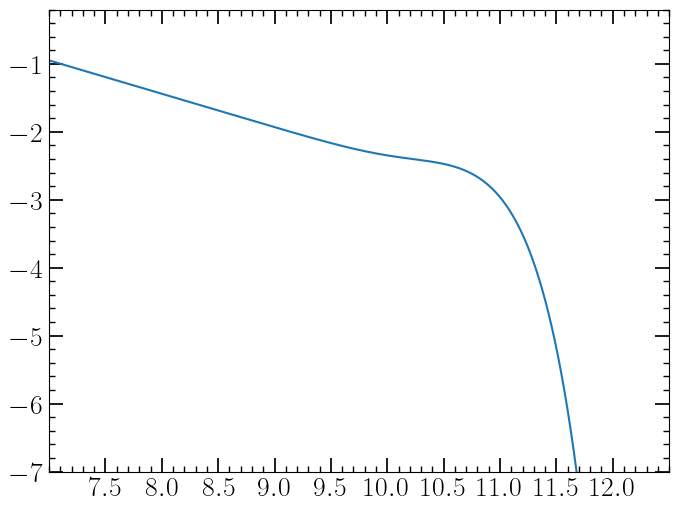

Match is not exact, but lets continue for now


In [52]:
GSMF_INTRINSIC_PARAMS = {
    "a1":  [10.55, 0.03, 0.03],
    "a2":  [0.00, 0.02, 0.02],
    "a3":  [-0.16, 0.10, 0.15],
    "a4":  [0.12,  0.12, 0.11],
    "a5":  [-1.45, 0.02, 0.02],
    "a6":  [-0.08, 0.02, 0.02],
    "a7":  [-2.43, 0.04, 0.04],
    "a8":  [-0.17, 0.05, 0.05],
    "a9":  [-0.08, 0.02, 0.02],
    "a10": [-2.94, 0.05, 0.05],
    "a11": [-0.22, 0.04, 0.04],
}


def GSMF_log10_M_star_zevo(z):
    a1, a2 = GSMF_INTRINSIC_PARAMS['a1'][0], GSMF_INTRINSIC_PARAMS['a2'][0]
    return a1 + a2 * z


def alpha1_zevo(z):
    a3, a4 = GSMF_INTRINSIC_PARAMS['a3'][0], GSMF_INTRINSIC_PARAMS['a4'][0]
    return a3 + a4 * z


def alpha2_zevo(z):
    a5, a6 = GSMF_INTRINSIC_PARAMS['a5'][0], GSMF_INTRINSIC_PARAMS['a6'][0]
    return a5 + a6 * z


def log10_phi_star1_zevo(z):
    a7, a8, a9 = GSMF_INTRINSIC_PARAMS['a7'][0], GSMF_INTRINSIC_PARAMS['a8'][0], GSMF_INTRINSIC_PARAMS['a9'][0]
    return a7 + a8 * z + a9 * z**2


def log10_phi_star2_zevo(z):
    a10, a11 = GSMF_INTRINSIC_PARAMS['a10'][0], GSMF_INTRINSIC_PARAMS['a11'][0]
    return a10 + a11 * z


def log10_GSMF_double_schechter(log10_M_solmass, z):

    log10_Mstar = GSMF_log10_M_star_zevo(z)
    phistar1 = 10**log10_phi_star1_zevo(z)
    phistar2 = 10**log10_phi_star2_zevo(z)
    alpha1 = alpha1_zevo(z)
    alpha2 = alpha2_zevo(z)

    M_minus_Mstar = log10_M_solmass - log10_Mstar

    factor1 = np.log(10) * np.exp(-10**(M_minus_Mstar)) * 10**(M_minus_Mstar)
    factor2 = phistar1 * 10**(alpha1 * M_minus_Mstar) + phistar2 * 10**(alpha2 * M_minus_Mstar)
    return np.log10(factor1 * factor2)


z = 0.5
mm = np.linspace(7, 12.5, 1000)
plt.figure(figsize=(8,6))
plt.xticks([7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12])
plt.xlim(7, 12.5)
plt.ylim(-7, -0.2)
plt.plot(mm, log10_GSMF_double_schechter(mm, z))
plt.show()

print('Match is not exact, but lets continue for now')

1025it [00:02, 351.69it/s]


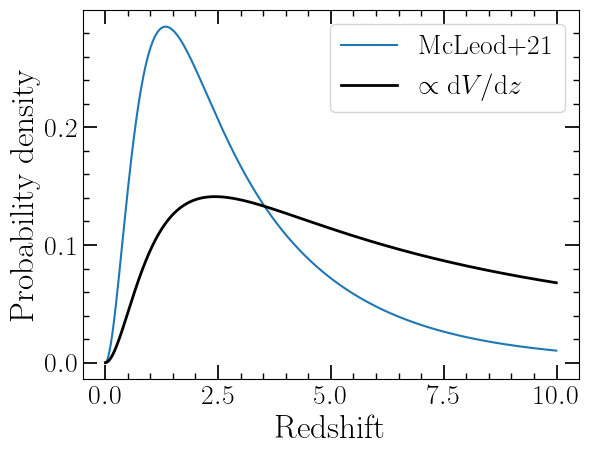

In [51]:
Mmin = 9
Mmax = 12.0
zmin = 1e-4
zmax = 10
redshift_bin_edges = np.linspace(zmin, zmax, 1024+2)
redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2

mass_integrate_axis = np.linspace(Mmin, Mmax, int(1024)+1)
n_of_z = lambda z: romb(10**log10_GSMF_double_schechter(mass_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mass_integrate_axis)[0], axis=0)

# numdenses = n_of_z(redshift_bin_edges).flatten()

n_gal_in_zbin = np.zeros_like(redshift_bin_centers)
for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
    zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
    z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

    numdens_in_bin = n_of_z(z_integrate_ax)
    n_gal_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])

gal_redshift_pdf = n_gal_in_zbin / romb(n_gal_in_zbin, dx=np.diff(redshift_bin_centers)[0])

plt.figure()
plt.plot(redshift_bin_centers, gal_redshift_pdf, label='McLeod+21')
plt.plot(redshift_bin_centers, uniform_comoving_prior(redshift_bin_centers) / romb(uniform_comoving_prior(redshift_bin_centers), dx=np.diff(redshift_bin_centers)[0]), 
             label=r'$\propto \mathrm{d}V / \mathrm{d}z$', color='black', linewidth=2)
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.legend()
plt.show()
